In [2]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq
from jax.config import config

config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

2023-01-18 14:23:48.567553: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-18 14:23:51.258655: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-18 14:23:51.621793: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dyn

In [3]:
import yaml

with open(
    "/home/icb/giovanni.palla/code/moscot_benchmarks/experiments/space/mapping/method_benchmark/config.yaml",
    "r",
) as stream:
    out = yaml.safe_load(stream)
datasets = out["grid"]["dataset"]["options"]
n_cells = []
for d in datasets:
    n_cells.append(sc.read(path_read / f"dataset{d}_sp.h5ad").shape[0])

In [4]:
np.random.normal(size=(20, 2)).mean()

-0.12406241745402391

In [5]:
df = pd.DataFrame({"dataset": datasets, "n_cells": n_cells})
df.sort_values(by="n_cells")

,dataset,n_cells
0,30,2064
1,37,2125
2,45,2177
3,26,2425
4,22,2432
5,33,3024
6,32,3024
7,14,3039
8,3,3585
9,20,4784


In [6]:
df.sort_values(by="n_cells").dataset.to_list()

[30, 37, 45, 26, 22, 33, 32, 14, 3, 20, 21, 41, 1, 39]

In [7]:
datasets = os.listdir(path_read)

In [8]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/DataUpload")
dataset = 14
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

# adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
# adata_sp_a = adata_sp.copy()
# adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()
adata_sp_b = adata_sp.copy()
sc_count = pd.read_csv(
    path_read / f"Dataset{dataset}" / "scRNA_count.txt", sep="\t", header=0, index_col=0
).T
adata_sp_a = AnnData(csr_matrix(sc_count.to_numpy()), dtype=sc_count.to_numpy().dtype)
adata_sp_a.var_names = sc_count.columns.tolist()
sc.pp.filter_cells(adata_sp_a, min_counts=10)
sc.pp.filter_genes(adata_sp_a, min_counts=2)
adata_sp_a.layers["counts"] = adata_sp_a.X.copy()
if adata_sp_a.shape[1] > 5000:
    sc.pp.highly_variable_genes(
        adata_sp_a, flavor="seurat_v3", n_top_genes=2000, subset=True
    )
sc.pp.normalize_total(adata_sp_a)
sc.pp.log1p(adata_sp_a)

intersect_var = list(set(adata_sp_a.var_names).intersection(set(adata_sp_b.var_names)))

# adata_sp_a = adata_sp_a[:, intersect_var].copy()
adata_sp_b = adata_sp_b[:, intersect_var].copy()

test_var = rng.choice(adata_sp_b.var_names, n_genes, replace=False).tolist()
if "eve" is not test_var:
    test_var.append("eve")
train_var = adata_sp_b.var_names[~np.in1d(adata_sp_b.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_203803/2969005779.py:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "eve" is not test_var:


In [9]:
adata_sc = adata_sp_a
adata_sp_train = adata_sp_b_train

In [58]:
params = {"epsilon": 1e-3, "alpha": 0.4}
epsilon, alpha = params["epsilon"], params["alpha"]

In [59]:
from moscot.problems.space import MappingProblem

prob = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_train)
prob = prob.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"},
    sp_attr={"attr": "obsm", "key": "spatial"},
    var_names=adata_sp_train.var_names.values,
    callback="local-pca" if adata_sp_train.shape[1] > 100 else None,
    kwargs={"joint-space": True},
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [60]:
print(
    prob.problems[("src", "tgt")].xy.shape,
    prob.problems[("src", "tgt")].xy.shape,
)

(3039, 1297) (3039, 1297)


In [61]:
prob = prob.solve(
    alpha=alpha,
    epsilon=epsilon,
    threshold=1e-8,
    max_iterations=100,  # tau_a=1., tau_b=1.
)
print(prob.solutions[list(prob.solutions.keys())[0]].converged)
print(prob.solutions[list(prob.solutions.keys())[0]].cost)

INFO     Solving problem OTProblem[stage='prepared', shape=(3039, 1297)].                                          
WARNING  Solver did not converge                                                                                   
False
1.9463171895140017


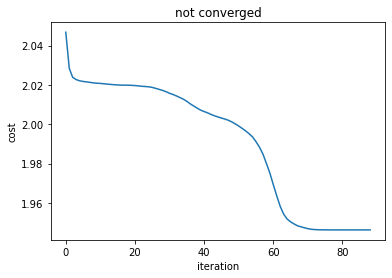

In [62]:
prob[("src", "tgt")].solution.plot_convergence()

In [63]:
adata_pred = prob.impute(var_names=true_df.columns.tolist(), device="cpu")
# pred_df = sc.get.obs_df(adata_pred, keys=true_df.columns.tolist())

In [64]:
adata_pred.var_names

Index(['ems', 'htl', 'erm', 'run', 'pxb', 'apt', 'bmm', 'Doc3', 'ftz', 'kni',
       'eve'],
      dtype='object')

In [65]:
pred_df = sc.get.obs_df(adata_pred, keys=adata_pred.var_names.tolist())

In [66]:
corr_pearson = pred_df.corrwith(true_df, method="pearson")
corr_spearman = pred_df.corrwith(true_df, method="spearman")

In [67]:
out = pd.concat([corr_pearson, corr_spearman], axis=1)
out.columns = ["pearson", "spearman"]

In [68]:
out.max(0)

pearson     0.464101
spearman    0.346077
dtype: float64

In [69]:
out.mean(0)

pearson     0.179615
spearman    0.160550
dtype: float64

In [70]:
out

,pearson,spearman
ems,-0.022326,-0.051724
htl,0.292463,0.312615
erm,-0.020609,-0.008570
run,0.098344,0.107369
pxb,0.193934,0.201144
apt,0.139495,0.090170
bmm,-0.030773,-0.043624
Doc3,0.464101,0.285027
ftz,0.363865,0.346077
kni,0.245720,0.290722


In [71]:
adata_sp.var_names

Index(['aay', 'Ama', 'Ance', 'Antp', 'apt', 'Blimp-1', 'bmm', 'bowl', 'brk',
       'Btk29A', 'bun', 'cad', 'CenG1A', 'CG10479', 'CG11208', 'CG14427',
       'CG17724', 'CG17786', 'CG43394', 'CG8147', 'cnc', 'croc', 'Cyp310a1',
       'D', 'dan', 'danr', 'Dfd', 'disco', 'Doc2', 'Doc3', 'dpn', 'edl', 'ems',
       'erm', 'Esp', 'E(spl)m5-HLH', 'eve', 'exex', 'fj', 'fkh', 'ftz', 'gk',
       'gt', 'h', 'hb', 'hkb', 'htl', 'Ilp4', 'ImpE2', 'ImpL2', 'ken', 'kni',
       'knrl', 'Kr', 'lok', 'Mdr49', 'Mes2', 'MESR3', 'mfas', 'Nek2', 'NetA',
       'noc', 'nub', 'numb', 'oc', 'odd', 'peb', 'prd', 'pxb', 'rau', 'rho',
       'run', 'sna', 'srp', 'tkv', 'tll', 'toc', 'Traf4', 'trn', 'tsh', 'twi',
       'zen', 'zen2', 'zfh1'],
      dtype='object')

In [72]:
adata_pred.obsm["spatial"] = adata_sp_b.obsm["spatial"].copy()

In [73]:
adata_sp.obsm["spatial "] = adata_sp.obsm["spatial"][:, [0, 2]]
adata_pred.obsm["spatial "] = adata_pred.obsm["spatial"][:, [0, 2]]

In [74]:
adata_pred.var_names

Index(['ems', 'htl', 'erm', 'run', 'pxb', 'apt', 'bmm', 'Doc3', 'ftz', 'kni',
       'eve'],
      dtype='object')

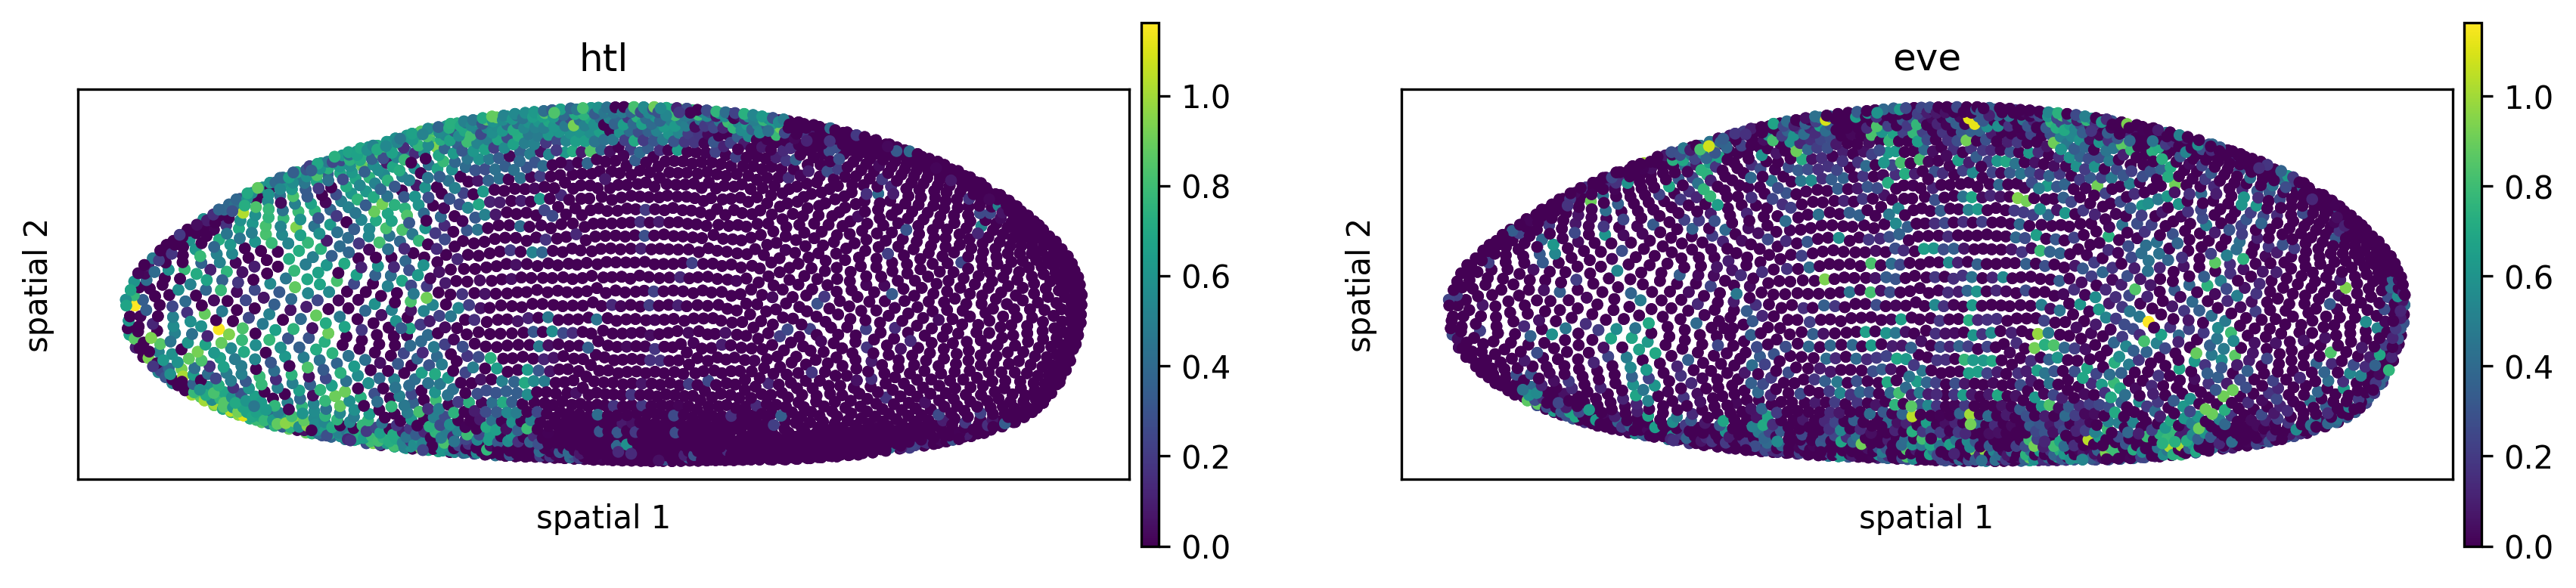

In [75]:
sq.pl.spatial_scatter(
    adata_pred,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=30,
    dpi=300,
    figsize=(6, 3),
)

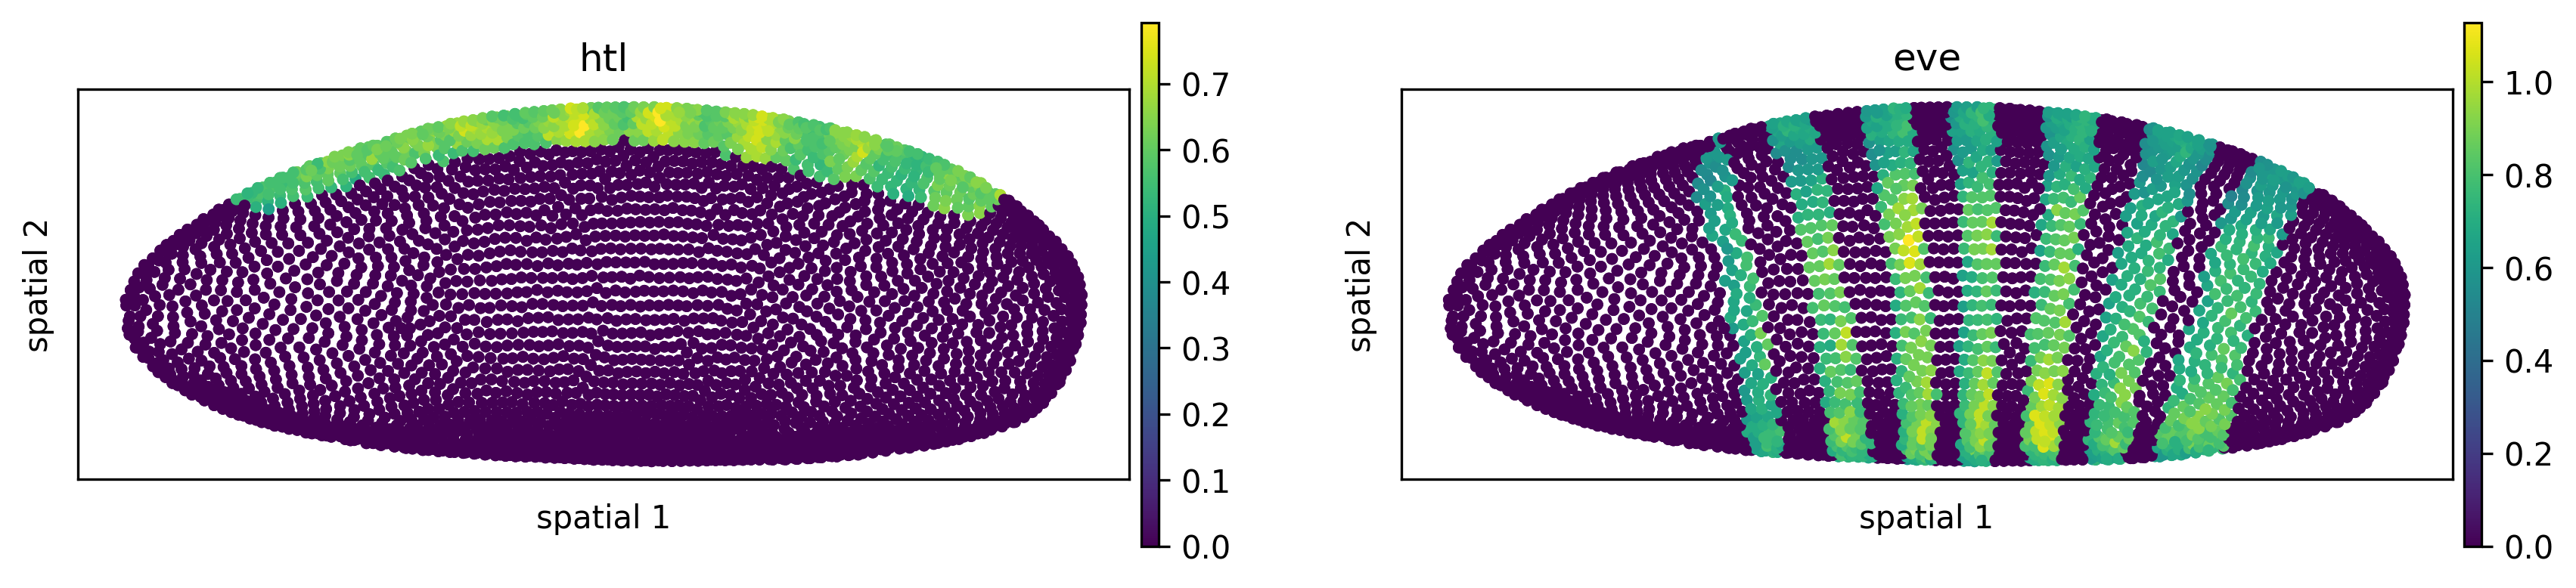

In [76]:
sq.pl.spatial_scatter(
    adata_sp,
    spatial_key="spatial ",
    color=["htl", "eve"],
    shape=None,
    size=30,
    dpi=300,
    figsize=(6, 3),
)

In [150]:
# sq.pl.spatial_scatter(adata_sp_b, color=["Esyt2"], shape=None)